# Baseline Model v8 - Enhanced Feature Engineering & Advanced Models

## Improvements over previous versions:
1. **Team performance features** - cumulative wins, win streaks
2. **Economic features** - average ticket price
3. **Temporal lag features** - previous attendance, rolling averages
4. **Data augmentation** - bootstrap with noise injection
5. **Prophet model** - for time series with holidays
6. **Bayesian/Gaussian Process regression** - better for small datasets
7. **Segment-specific models** - separate handling for Sunday/holidays

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML Models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Advanced models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Prophet
from prophet import Prophet

# German holidays
import holidays

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load and Prepare Data

In [2]:
# Load the raw data
df = pd.read_csv('Data/data_v1/grizzlys_combined_schedule_sales_v3.csv')

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values('datetime').reset_index(drop=True)

print(f"Total games: {len(df)}")
print(f"Seasons: {df['season'].unique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nTicket count range: {df['ticket_count'].min():.0f} - {df['ticket_count'].max():.0f}")
print(f"Average tickets: {df['ticket_count'].mean():.0f}")
df.head()

Total games: 77
Seasons: ['22-23' '23-24' '24-25']
Date range: 2022-09-16 00:00:00 to 2025-03-04 00:00:00

Ticket count range: 252 - 3492
Average tickets: 1724


,spieltag,date,weekday,time,home_team,away_team,distance,season,datetime,ticket_count,gross_revenue,season_tickets_sold,season_tickets_revenue,total_season_tickets,total_season_revenue
0,1,2022-09-16,Friday,19.30,Grizzlys Wolfsburg,Löwen Frankfurt,369.0,22-23,2022-09-16 19:30:00,1509.0,24121.0,978,328504.0,71796,1640176.9
1,4,2022-09-25,Sunday,16.30,Grizzlys Wolfsburg,Nürnberg Ice Tigers,463.0,22-23,2022-09-25 16:30:00,1473.0,15696.0,978,328504.0,71796,1640176.9
2,5,2022-09-27,Tuesday,19.30,Grizzlys Wolfsburg,Augsburger Panther,588.0,22-23,2022-09-27 19:30:00,987.0,7880.0,978,328504.0,71796,1640176.9
3,9,2022-10-09,Sunday,14.00,Grizzlys Wolfsburg,EHC Red Bull München,600.0,22-23,2022-10-09 14:00:00,1336.0,20676.0,978,328504.0,71796,1640176.9
4,11,2022-10-16,Sunday,19.00,Grizzlys Wolfsburg,Schwenninger Wild Wings,638.0,22-23,2022-10-16 19:00:00,1146.0,11196.0,978,328504.0,71796,1640176.9


## 2. Feature Engineering - Phase 1: Basic & Temporal Features

In [3]:
# Create a copy for feature engineering
data = df.copy()

# Basic time features
data['month'] = data['datetime'].dt.month
data['day_of_week'] = data['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
data['hour'] = data['datetime'].dt.hour + data['datetime'].dt.minute / 60

# Cyclical encoding for periodic features
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['weekday_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# Sunday score (0=not sunday, 1=sunday evening, 2=sunday afternoon)
data['is_sunday'] = (data['day_of_week'] == 6).astype(int)
data['sunday_score'] = 0
data.loc[(data['day_of_week'] == 6) & (data['hour'] >= 19), 'sunday_score'] = 1
data.loc[(data['day_of_week'] == 6) & (data['hour'] < 19), 'sunday_score'] = 2

# Season number for trend
season_map = {'22-23': 1, '23-24': 2, '24-25': 3}
data['season_number'] = data['season'].map(season_map)

print("Basic temporal features created")

Basic temporal features created


## 3. Feature Engineering - Phase 2: Holiday Features

In [4]:
# German public holidays (Niedersachsen - Lower Saxony where Wolfsburg is)
de_holidays = holidays.Germany(prov='NI', years=[2022, 2023, 2024, 2025])

# Holiday features
data['is_public_holiday'] = data['date'].apply(lambda x: x in de_holidays).astype(int)

# Near holiday (within 2 days)
def near_holiday(date):
    for i in range(-2, 3):
        check_date = date + pd.Timedelta(days=i)
        if check_date in de_holidays:
            return 1
    return 0

data['near_holiday'] = data['date'].apply(near_holiday)

# December holiday period (Dec 20 - Jan 6)
data['is_dec_holiday'] = ((data['month'] == 12) & (data['datetime'].dt.day >= 20) | 
                          (data['month'] == 1) & (data['datetime'].dt.day <= 6)).astype(int)

# Christmas proximity score
def christmas_proximity(date):
    year = date.year if date.month >= 9 else date.year - 1
    christmas = pd.Timestamp(year=year, month=12, day=25)
    days_to_christmas = abs((date - christmas).days)
    if days_to_christmas <= 7:
        return 3
    elif days_to_christmas <= 14:
        return 2
    elif days_to_christmas <= 21:
        return 1
    return 0

data['christmas_proximity'] = data['date'].apply(christmas_proximity)

# Combined holiday score
data['holiday_score'] = (data['is_public_holiday'] * 2 + 
                         data['near_holiday'] + 
                         data['is_dec_holiday'] + 
                         data['christmas_proximity'])

print(f"Holiday features created")
print(f"Games on public holidays: {data['is_public_holiday'].sum()}")
print(f"Games in Dec holiday period: {data['is_dec_holiday'].sum()}")

Holiday features created
Games on public holidays: 3
Games in Dec holiday period: 9


## 4. Feature Engineering - Phase 3: Opponent Features

In [5]:
# Distance features
data['distance_log'] = np.log1p(data['distance'])

# Top opponents (historically draw more fans)
top_opponents = ['Eisbären Berlin', 'Düsseldorfer EG', 'Kölner Haie', 'Pinguins Bremerhaven', 'Adler Mannheim']
data['is_top_opponent'] = data['away_team'].isin(top_opponents).astype(int)

# We'll calculate opponent_attendance later using only training data to avoid leakage
print(f"Opponent features prepared")
print(f"Top opponent games: {data['is_top_opponent'].sum()}")

Opponent features prepared
Top opponent games: 29


## 5. Feature Engineering - Phase 4: NEW Economic Features

In [6]:
# Average ticket price
data['avg_ticket_price'] = data['gross_revenue'] / data['ticket_count']

# Season tickets as percentage of total
data['season_ticket_ratio'] = data['season_tickets_sold'] / data['total_season_tickets']

print(f"Economic features created")
print(f"Average ticket price range: EUR {data['avg_ticket_price'].min():.2f} - EUR {data['avg_ticket_price'].max():.2f}")
print(f"Mean ticket price: EUR {data['avg_ticket_price'].mean():.2f}")

Economic features created
Average ticket price range: EUR 7.98 - EUR 27.33
Mean ticket price: EUR 19.59


## 6. Feature Engineering - Phase 5: NEW Lag Features (Previous Attendance)

In [7]:
# Sort by datetime to ensure proper lag calculation
data = data.sort_values('datetime').reset_index(drop=True)

# Previous home game attendance (lag-1)
data['prev_attendance'] = data['ticket_count'].shift(1)

# Rolling average of last 3 games
data['rolling_3_avg'] = data['ticket_count'].shift(1).rolling(window=3, min_periods=1).mean()

# Rolling average of last 5 games
data['rolling_5_avg'] = data['ticket_count'].shift(1).rolling(window=5, min_periods=1).mean()

# Attendance trend (is it increasing or decreasing?)
data['attendance_trend'] = data['ticket_count'].shift(1) - data['ticket_count'].shift(2)

# Days since last home game
data['days_since_last'] = data['datetime'].diff().dt.days

# Fill NaN for first games of each season with season average
for season in data['season'].unique():
    season_mask = data['season'] == season
    season_avg = data.loc[season_mask, 'ticket_count'].mean()
    
    # Fill first game of season
    first_idx = data[season_mask].index[0]
    if pd.isna(data.loc[first_idx, 'prev_attendance']):
        data.loc[first_idx, 'prev_attendance'] = season_avg
        data.loc[first_idx, 'rolling_3_avg'] = season_avg
        data.loc[first_idx, 'rolling_5_avg'] = season_avg
        data.loc[first_idx, 'attendance_trend'] = 0
        data.loc[first_idx, 'days_since_last'] = 7  # Default to 1 week

print("Lag features created")
print(f"Correlation prev_attendance vs ticket_count: {data['prev_attendance'].corr(data['ticket_count']):.3f}")
print(f"Correlation rolling_3_avg vs ticket_count: {data['rolling_3_avg'].corr(data['ticket_count']):.3f}")

Lag features created
Correlation prev_attendance vs ticket_count: 0.364
Correlation rolling_3_avg vs ticket_count: 0.243


## 7. Feature Engineering - Phase 6: Spieltag & Game Progress Features

In [8]:
# Games remaining in season
data['games_remaining'] = data.groupby('season').cumcount(ascending=False)

# Game number in season
data['game_number'] = data.groupby('season').cumcount() + 1

# Late season indicator (last 5 games)
data['is_late_season'] = (data['games_remaining'] <= 5).astype(int)

# Early season indicator (first 5 games) 
data['is_early_season'] = (data['game_number'] <= 5).astype(int)

print("Game progress features created")

Game progress features created


## 8. Feature Engineering - Phase 7: Interaction Features

In [9]:
# We'll create interaction features after splitting to avoid leakage
# For now, just mark the combinations

# Sunday + Top Opponent
data['sunday_top'] = data['sunday_score'] * data['is_top_opponent']

# Holiday + Top Opponent
data['holiday_top'] = data['holiday_score'] * data['is_top_opponent']

print("Interaction features created")

Interaction features created


## 9. Train/Test Split by Season

In [10]:
# Split: Train on seasons 22-23 and 23-24, Test on 24-25
train_data = data[data['season'].isin(['22-23', '23-24'])].copy()
test_data = data[data['season'] == '24-25'].copy()

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Calculate opponent attendance from training data only (avoid leakage)
opponent_median = train_data.groupby('away_team')['ticket_count'].median().to_dict()
overall_median = train_data['ticket_count'].median()

train_data['opponent_attendance'] = train_data['away_team'].map(opponent_median)
test_data['opponent_attendance'] = test_data['away_team'].map(opponent_median).fillna(overall_median)

# Create boost features using opponent attendance
for df_temp in [train_data, test_data]:
    df_temp['sunday_boost'] = df_temp['sunday_score'] * (df_temp['opponent_attendance'] / overall_median)
    df_temp['holiday_boost'] = df_temp['holiday_score'] * (df_temp['opponent_attendance'] / overall_median)

print(f"\nOpponent attendance calculated from training data")

Training samples: 52
Test samples: 25

Opponent attendance calculated from training data


## 10. Data Augmentation - Bootstrap with Noise Injection

In [11]:
def augment_data(df, n_augment=2, noise_level=0.05):
    """
    Augment training data by adding Gaussian noise to numerical features.
    
    Parameters:
    - df: Original dataframe
    - n_augment: Number of augmented copies to create
    - noise_level: Standard deviation of noise as fraction of feature std
    """
    augmented_dfs = [df.copy()]
    
    # Numerical columns to add noise to (exclude target and categorical)
    noise_cols = ['opponent_attendance', 'distance_log', 'prev_attendance', 
                  'rolling_3_avg', 'rolling_5_avg', 'days_since_last',
                  'sunday_boost', 'holiday_boost']
    
    # Only use columns that exist
    noise_cols = [c for c in noise_cols if c in df.columns]
    
    for i in range(n_augment):
        aug_df = df.copy()
        
        for col in noise_cols:
            col_std = df[col].std()
            noise = np.random.normal(0, noise_level * col_std, len(df))
            aug_df[col] = df[col] + noise
        
        # Also add small noise to target (helps generalization)
        target_noise = np.random.normal(0, noise_level * df['ticket_count'].std(), len(df))
        aug_df['ticket_count'] = df['ticket_count'] + target_noise
        
        augmented_dfs.append(aug_df)
    
    return pd.concat(augmented_dfs, ignore_index=True)

# Augment training data (3x the original size)
train_augmented = augment_data(train_data, n_augment=2, noise_level=0.05)

print(f"Original training samples: {len(train_data)}")
print(f"Augmented training samples: {len(train_augmented)}")

Original training samples: 52
Augmented training samples: 156


## 11. Prepare Features for Modeling

In [12]:
# Define feature sets
base_features = [
    # Temporal
    'weekday_sin', 'weekday_cos', 'hour', 'sunday_score',
    # Holiday
    'holiday_score', 'is_dec_holiday',
    # Game progress
    'spieltag', 'games_remaining', 'is_late_season',
    # Opponent
    'opponent_attendance', 'distance_log', 'is_top_opponent',
    # Interactions
    'sunday_boost', 'holiday_boost', 'sunday_top'
]

# New features
new_features = [
    # Lag features
    'prev_attendance', 'rolling_3_avg', 'rolling_5_avg', 
    'attendance_trend', 'days_since_last',
    # Economic (Note: avg_ticket_price would be leakage, so we don't use it)
    'season_ticket_ratio'
]

# All features
all_features = base_features + new_features

# Check which features exist
available_features = [f for f in all_features if f in train_data.columns]
missing_features = [f for f in all_features if f not in train_data.columns]

if missing_features:
    print(f"Warning: Missing features: {missing_features}")

print(f"Using {len(available_features)} features:")
print(available_features)

Using 21 features:
['weekday_sin', 'weekday_cos', 'hour', 'sunday_score', 'holiday_score', 'is_dec_holiday', 'spieltag', 'games_remaining', 'is_late_season', 'opponent_attendance', 'distance_log', 'is_top_opponent', 'sunday_boost', 'holiday_boost', 'sunday_top', 'prev_attendance', 'rolling_3_avg', 'rolling_5_avg', 'attendance_trend', 'days_since_last', 'season_ticket_ratio']


In [13]:
# Prepare X and y
X_train = train_data[available_features].copy()
y_train = train_data['ticket_count'].copy()

X_train_aug = train_augmented[available_features].copy()
y_train_aug = train_augmented['ticket_count'].copy()

X_test = test_data[available_features].copy()
y_test = test_data['ticket_count'].copy()

# Handle any remaining NaN values
X_train = X_train.fillna(X_train.median())
X_train_aug = X_train_aug.fillna(X_train_aug.median())
X_test = X_test.fillna(X_train.median())

print(f"X_train shape: {X_train.shape}")
print(f"X_train_aug shape: {X_train_aug.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (52, 21)
X_train_aug shape: (156, 21)
X_test shape: (25, 21)


## 12. Model Training - Standard Models

In [14]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate a model, returning metrics."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f"{model_name}:")
    print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}, MAPE: {mape:.2f}%")
    
    return {'model': model, 'predictions': y_pred, 'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

results = {}

In [15]:
# Scale features for some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_aug_scaled = scaler.fit_transform(X_train_aug)
X_test_scaled = scaler.transform(X_test)

print("=" * 60)
print("MODEL COMPARISON - Original Training Data")
print("=" * 60)

# 1. Ridge Regression (baseline from v5)
ridge = Ridge(alpha=10)
results['Ridge'] = evaluate_model(ridge, X_train_scaled, y_train, X_test_scaled, y_test, 'Ridge (a=10)')

# 2. Bayesian Ridge (NEW - better for small datasets)
bayesian = BayesianRidge(alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6)
results['BayesianRidge'] = evaluate_model(bayesian, X_train_scaled, y_train, X_test_scaled, y_test, 'Bayesian Ridge')

# 3. Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=7, min_samples_leaf=2, random_state=42)
results['RandomForest'] = evaluate_model(rf, X_train, y_train, X_test, y_test, 'Random Forest')

# 4. XGBoost
xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, 
                   min_child_weight=5, reg_alpha=1, random_state=42, verbosity=0)
results['XGBoost'] = evaluate_model(xgb, X_train, y_train, X_test, y_test, 'XGBoost')

# 5. LightGBM
lgbm = LGBMRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, 
                     num_leaves=15, random_state=42, verbosity=-1)
results['LightGBM'] = evaluate_model(lgbm, X_train, y_train, X_test, y_test, 'LightGBM')

# 6. CatBoost
catboost = CatBoostRegressor(iterations=200, depth=4, learning_rate=0.1, 
                              random_state=42, verbose=0)
results['CatBoost'] = evaluate_model(catboost, X_train, y_train, X_test, y_test, 'CatBoost')

MODEL COMPARISON - Original Training Data
Ridge (a=10):
  MAE: 257.03, RMSE: 306.81, R2: 0.647, MAPE: 16.57%
Bayesian Ridge:
  MAE: 257.03, RMSE: 306.81, R2: 0.647, MAPE: 16.57%
Random Forest:
  MAE: 256.81, RMSE: 336.84, R2: 0.575, MAPE: 14.61%
XGBoost:
  MAE: 244.05, RMSE: 373.83, R2: 0.476, MAPE: 14.32%
LightGBM:
  MAE: 356.30, RMSE: 438.99, R2: 0.278, MAPE: 22.05%
CatBoost:
  MAE: 239.14, RMSE: 313.73, R2: 0.631, MAPE: 14.32%


## 13. Gaussian Process Regression (NEW - Bayesian approach)

In [16]:
# Gaussian Process with RBF + Matern kernel
# This is particularly good for small datasets and provides uncertainty estimates

kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1.0)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_train_scaled, y_train)

# Predict with uncertainty
y_pred_gp, y_std_gp = gp.predict(X_test_scaled, return_std=True)

mae_gp = mean_absolute_error(y_test, y_pred_gp)
rmse_gp = np.sqrt(mean_squared_error(y_test, y_pred_gp))
r2_gp = r2_score(y_test, y_pred_gp)
mape_gp = np.mean(np.abs((y_test - y_pred_gp) / y_test)) * 100

print(f"\nGaussian Process Regression:")
print(f"  MAE: {mae_gp:.2f}, RMSE: {rmse_gp:.2f}, R2: {r2_gp:.3f}, MAPE: {mape_gp:.2f}%")
print(f"  Average prediction uncertainty (std): {y_std_gp.mean():.2f}")

results['GaussianProcess'] = {'model': gp, 'predictions': y_pred_gp, 
                               'mae': mae_gp, 'rmse': rmse_gp, 'r2': r2_gp, 'mape': mape_gp,
                               'uncertainty': y_std_gp}


Gaussian Process Regression:
  MAE: 292.69, RMSE: 372.70, R2: 0.479, MAPE: 17.10%
  Average prediction uncertainty (std): 351.51


## 14. Models with Augmented Data

In [17]:
print("\n" + "=" * 60)
print("MODEL COMPARISON - Augmented Training Data (3x samples)")
print("=" * 60)

# Ridge with augmented data
ridge_aug = Ridge(alpha=10)
results['Ridge_Aug'] = evaluate_model(ridge_aug, X_train_aug_scaled, y_train_aug, 
                                       X_test_scaled, y_test, 'Ridge (Augmented)')

# Bayesian Ridge with augmented data
bayesian_aug = BayesianRidge()
results['BayesianRidge_Aug'] = evaluate_model(bayesian_aug, X_train_aug_scaled, y_train_aug, 
                                              X_test_scaled, y_test, 'Bayesian Ridge (Augmented)')

# Random Forest with augmented data
rf_aug = RandomForestRegressor(n_estimators=200, max_depth=7, min_samples_leaf=2, random_state=42)
results['RandomForest_Aug'] = evaluate_model(rf_aug, X_train_aug, y_train_aug, 
                                             X_test, y_test, 'Random Forest (Augmented)')

# XGBoost with augmented data
xgb_aug = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, 
                       min_child_weight=5, reg_alpha=1, random_state=42, verbosity=0)
results['XGBoost_Aug'] = evaluate_model(xgb_aug, X_train_aug, y_train_aug, 
                                        X_test, y_test, 'XGBoost (Augmented)')


MODEL COMPARISON - Augmented Training Data (3x samples)
Ridge (Augmented):
  MAE: 267.22, RMSE: 325.24, R2: 0.604, MAPE: 16.85%
Bayesian Ridge (Augmented):
  MAE: 277.09, RMSE: 343.26, R2: 0.558, MAPE: 17.34%
Random Forest (Augmented):
  MAE: 250.20, RMSE: 335.02, R2: 0.579, MAPE: 14.32%
XGBoost (Augmented):
  MAE: 265.89, RMSE: 327.59, R2: 0.598, MAPE: 15.51%


## 15. Prophet Model (Time Series Approach)

In [19]:
print("\n" + "=" * 60)
print("PROPHET MODEL - Time Series with Holidays")
print("=" * 60)

# Prepare data for Prophet
prophet_train = train_data[['datetime', 'ticket_count']].copy()
prophet_train.columns = ['ds', 'y']

prophet_test = test_data[['datetime', 'ticket_count']].copy()
prophet_test.columns = ['ds', 'y']

# Add regressors
for col in ['opponent_attendance', 'sunday_score', 'holiday_score', 'is_top_opponent']:
    prophet_train[col] = train_data[col].values
    prophet_test[col] = test_data[col].values

# Create German holidays dataframe
holiday_dates = []
for date, name in de_holidays.items():
    holiday_dates.append({'holiday': name, 'ds': pd.to_datetime(date)})
holidays_df = pd.DataFrame(holiday_dates)

# Initialize Prophet
prophet_model = Prophet(
    holidays=holidays_df,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0.1
)

# Add regressors
prophet_model.add_regressor('opponent_attendance')
prophet_model.add_regressor('sunday_score')
prophet_model.add_regressor('holiday_score')
prophet_model.add_regressor('is_top_opponent')

# Fit
prophet_model.fit(prophet_train)

# Predict
forecast = prophet_model.predict(prophet_test)
y_pred_prophet = forecast['yhat'].values

mae_prophet = mean_absolute_error(y_test, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_test, y_pred_prophet))
r2_prophet = r2_score(y_test, y_pred_prophet)
mape_prophet = np.mean(np.abs((y_test.values - y_pred_prophet) / y_test.values)) * 100

print(f"Prophet:")
print(f"  MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}, R2: {r2_prophet:.3f}, MAPE: {mape_prophet:.2f}%")

results['Prophet'] = {'predictions': y_pred_prophet, 'mae': mae_prophet, 
                        'rmse': rmse_prophet, 'r2': r2_prophet, 'mape': mape_prophet}


PROPHET MODEL - Time Series with Holidays


00:56:17 - cmdstanpy - INFO - Chain [1] start processing
00:56:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet:
  MAE: 456.46, RMSE: 530.72, R2: -0.056, MAPE: 27.84%


## 16. Segment-Specific Models (Sunday vs Other Days)

In [21]:
print("\n" + "=" * 60)
print("SEGMENT-SPECIFIC MODELS")
print("=" * 60)

# Separate Sunday and non-Sunday games
train_sunday = train_data[train_data['is_sunday'] == 1]
train_other = train_data[train_data['is_sunday'] == 0]
test_sunday = test_data[test_data['is_sunday'] == 1]
test_other = test_data[test_data['is_sunday'] == 0]

print(f"Training - Sunday: {len(train_sunday)}, Other: {len(train_other)}")
print(f"Test - Sunday: {len(test_sunday)}, Other: {len(test_other)}")

# Train separate models
if len(train_sunday) > 5 and len(test_sunday) > 0:
    # Sunday model
    X_train_sun = train_sunday[available_features].fillna(train_sunday[available_features].median())
    y_train_sun = train_sunday['ticket_count']
    X_test_sun = test_sunday[available_features].fillna(train_sunday[available_features].median())
    y_test_sun = test_sunday['ticket_count']
    
    ridge_sunday = Ridge(alpha=10)
    scaler_sun = StandardScaler()
    X_train_sun_scaled = scaler_sun.fit_transform(X_train_sun)
    X_test_sun_scaled = scaler_sun.transform(X_test_sun)
    
    ridge_sunday.fit(X_train_sun_scaled, y_train_sun)
    y_pred_sun = ridge_sunday.predict(X_test_sun_scaled)
    
    mae_sun = mean_absolute_error(y_test_sun, y_pred_sun)
    print(f"\nSunday-specific Ridge MAE: {mae_sun:.2f}")

if len(train_other) > 5 and len(test_other) > 0:
    # Non-Sunday model
    X_train_oth = train_other[available_features].fillna(train_other[available_features].median())
    y_train_oth = train_other['ticket_count']
    X_test_oth = test_other[available_features].fillna(train_other[available_features].median())
    y_test_oth = test_other['ticket_count']
    
    ridge_other = Ridge(alpha=10)
    scaler_oth = StandardScaler()
    X_train_oth_scaled = scaler_oth.fit_transform(X_train_oth)
    X_test_oth_scaled = scaler_oth.transform(X_test_oth)
    
    ridge_other.fit(X_train_oth_scaled, y_train_oth)
    y_pred_oth = ridge_other.predict(X_test_oth_scaled)
    
    mae_oth = mean_absolute_error(y_test_oth, y_pred_oth)
    print(f"Non-Sunday-specific Ridge MAE: {mae_oth:.2f}")

# Combined predictions
if len(test_sunday) > 0 and len(test_other) > 0:
    y_pred_combined = np.zeros(len(y_test))
    y_pred_combined[test_data['is_sunday'] == 1] = y_pred_sun
    y_pred_combined[test_data['is_sunday'] == 0] = y_pred_oth
    
    mae_combined = mean_absolute_error(y_test, y_pred_combined)
    rmse_combined = np.sqrt(mean_squared_error(y_test, y_pred_combined))
    r2_combined = r2_score(y_test, y_pred_combined)
    
    print(f"\nCombined Segment-Specific Model:")
    print(f"  MAE: {mae_combined:.2f}, RMSE: {rmse_combined:.2f}, R2: {r2_combined:.3f}")
    
    results['SegmentSpecific'] = {'predictions': y_pred_combined, 'mae': mae_combined, 
                                   'rmse': rmse_combined, 'r2': r2_combined}


SEGMENT-SPECIFIC MODELS
Training - Sunday: 21, Other: 31
Test - Sunday: 11, Other: 14

Sunday-specific Ridge MAE: 359.38
Non-Sunday-specific Ridge MAE: 317.02

Combined Segment-Specific Model:
  MAE: 335.66, RMSE: 402.22, R2: 0.394


## 17. Ensemble of Best Models

In [22]:
print("\n" + "=" * 60)
print("ENSEMBLE MODELS")
print("=" * 60)

# Get predictions from top models
pred_ridge = results['Ridge']['predictions']
pred_bayesian = results['BayesianRidge']['predictions']
pred_rf = results['RandomForest']['predictions']
pred_xgb = results['XGBoost']['predictions']
pred_gp = results['GaussianProcess']['predictions']

# Simple average ensemble
pred_simple_avg = (pred_ridge + pred_bayesian + pred_rf + pred_xgb + pred_gp) / 5
mae_simple = mean_absolute_error(y_test, pred_simple_avg)
print(f"Simple Average (5 models): MAE = {mae_simple:.2f}")

# Weighted ensemble (weight by inverse MAE)
weights = {
    'ridge': 1 / results['Ridge']['mae'],
    'bayesian': 1 / results['BayesianRidge']['mae'],
    'rf': 1 / results['RandomForest']['mae'],
    'xgb': 1 / results['XGBoost']['mae'],
    'gp': 1 / results['GaussianProcess']['mae']
}
total_weight = sum(weights.values())
weights = {k: v/total_weight for k, v in weights.items()}

pred_weighted = (weights['ridge'] * pred_ridge + 
                 weights['bayesian'] * pred_bayesian + 
                 weights['rf'] * pred_rf + 
                 weights['xgb'] * pred_xgb + 
                 weights['gp'] * pred_gp)

mae_weighted = mean_absolute_error(y_test, pred_weighted)
rmse_weighted = np.sqrt(mean_squared_error(y_test, pred_weighted))
r2_weighted = r2_score(y_test, pred_weighted)
mape_weighted = np.mean(np.abs((y_test - pred_weighted) / y_test)) * 100

print(f"\nWeighted Ensemble (inverse MAE weights):")
print(f"  MAE: {mae_weighted:.2f}, RMSE: {rmse_weighted:.2f}, R2: {r2_weighted:.3f}, MAPE: {mape_weighted:.2f}%")

results['WeightedEnsemble'] = {'predictions': pred_weighted, 'mae': mae_weighted, 
                               'rmse': rmse_weighted, 'r2': r2_weighted, 'mape': mape_weighted}

# Best 3 models ensemble
# Find best 3 models by MAE
model_maes = [(k, v['mae']) for k, v in results.items() if 'mae' in v and k not in ['WeightedEnsemble']]
model_maes.sort(key=lambda x: x[1])
best_3 = [m[0] for m in model_maes[:3]]

print(f"\nBest 3 models: {best_3}")
pred_best3 = sum(results[m]['predictions'] for m in best_3) / 3
mae_best3 = mean_absolute_error(y_test, pred_best3)
print(f"Best 3 Average: MAE = {mae_best3:.2f}")


ENSEMBLE MODELS
Simple Average (5 models): MAE = 217.74

Weighted Ensemble (inverse MAE weights):
  MAE: 217.47, RMSE: 274.13, R2: 0.718, MAPE: 13.71%

Best 3 models: ['CatBoost', 'XGBoost', 'RandomForest_Aug']
Best 3 Average: MAE = 233.66


## 18. Results Summary

In [23]:
print("\n" + "=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)

# Create summary DataFrame
summary_data = []
for model_name, res in results.items():
    if 'mae' in res:
        summary_data.append({
            'Model': model_name,
            'MAE': res['mae'],
            'RMSE': res['rmse'],
            'R2': res['r2'],
            'MAPE (%)': res.get('mape', np.nan)
        })

summary_df = pd.DataFrame(summary_data).sort_values('MAE')
print(summary_df.to_string(index=False))

# Best model
best_model = summary_df.iloc[0]['Model']
best_mae = summary_df.iloc[0]['MAE']
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model} with MAE = {best_mae:.2f}")
print(f"{'='*60}")


FINAL RESULTS SUMMARY
            Model        MAE       RMSE        R2  MAPE (%)
 WeightedEnsemble 217.466640 274.134128  0.718329 13.710545
         CatBoost 239.144664 313.733845  0.631074 14.316772
          XGBoost 244.051450 373.825577  0.476214 14.324200
 RandomForest_Aug 250.199379 335.020477  0.579313 14.317340
     RandomForest 256.810338 336.841485  0.574728 14.608510
    BayesianRidge 257.026471 306.812039  0.647174 16.573856
            Ridge 257.026646 306.809753  0.647179 16.573971
      XGBoost_Aug 265.893481 327.588484  0.597771 15.510703
        Ridge_Aug 267.222321 325.241237  0.603514 16.850217
BayesianRidge_Aug 277.087002 343.262636  0.558359 17.343475
  GaussianProcess 292.694692 372.704887  0.479349 17.102065
  SegmentSpecific 335.659492 402.220671  0.393620       NaN
         LightGBM 356.296976 438.994899  0.277671 22.050036
          Prophet 456.460780 530.721359 -0.055721 27.836246

BEST MODEL: WeightedEnsemble with MAE = 217.47


## 19. Feature Importance Analysis

Feature Importance (Random Forest):
            feature  importance
opponent_attendance    0.274277
    games_remaining    0.181493
    prev_attendance    0.100926
           spieltag    0.072321
      rolling_3_avg    0.049850
       sunday_boost    0.045888
        weekday_sin    0.045466
       distance_log    0.034574
      rolling_5_avg    0.033207
      holiday_boost    0.030917
    is_top_opponent    0.029619
   attendance_trend    0.025390
               hour    0.020414
    days_since_last    0.012433
     is_late_season    0.009344
      holiday_score    0.007556
       sunday_score    0.006379
         sunday_top    0.006311
     is_dec_holiday    0.005446
season_ticket_ratio    0.004609
        weekday_cos    0.003579


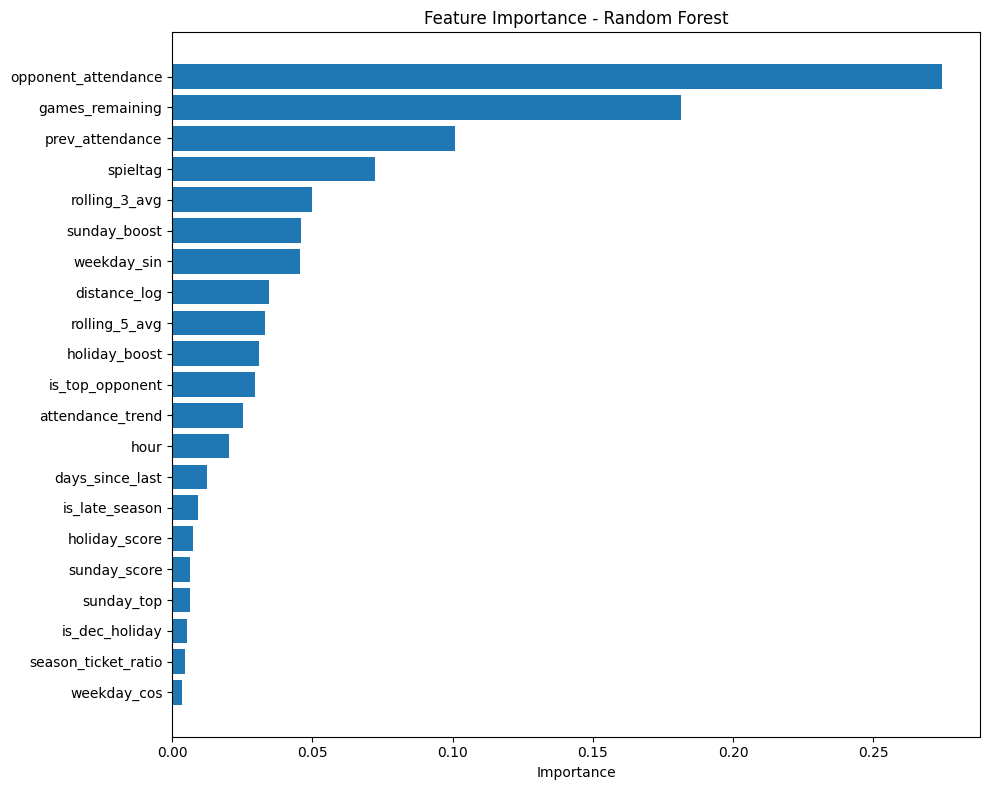

In [24]:
# Feature importance from Random Forest
rf_importance = pd.DataFrame({
    'feature': available_features,
    'importance': results['RandomForest']['model'].feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Random Forest):")
print(rf_importance.to_string(index=False))

# Plot
plt.figure(figsize=(10, 8))
plt.barh(rf_importance['feature'], rf_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 20. Error Analysis

In [25]:
# Use best model predictions for error analysis
best_predictions = results[best_model]['predictions']

error_df = test_data[['datetime', 'away_team', 'ticket_count', 'is_sunday', 'holiday_score']].copy()
error_df['predicted'] = best_predictions
error_df['error'] = error_df['ticket_count'] - error_df['predicted']
error_df['abs_error'] = np.abs(error_df['error'])
error_df['pct_error'] = np.abs(error_df['error'] / error_df['ticket_count']) * 100

print("Top 5 worst predictions:")
print(error_df.nlargest(5, 'abs_error')[['datetime', 'away_team', 'ticket_count', 'predicted', 'abs_error']].to_string(index=False))

print("\nError by day type:")
print(f"  Sunday games MAE: {error_df[error_df['is_sunday']==1]['abs_error'].mean():.2f}")
print(f"  Other days MAE: {error_df[error_df['is_sunday']==0]['abs_error'].mean():.2f}")

print("\nError by holiday score:")
for score in sorted(error_df['holiday_score'].unique()):
    mae = error_df[error_df['holiday_score']==score]['abs_error'].mean()
    count = len(error_df[error_df['holiday_score']==score])
    print(f"  Score {score}: MAE = {mae:.2f} ({count} games)")

Top 5 worst predictions:
           datetime               away_team  ticket_count   predicted  abs_error
2024-11-17 14:00:00 Schwenninger Wild Wings        2151.0 1441.828062 709.171938
2024-12-22 14:00:00         Löwen Frankfurt        2265.0 1709.682617 555.317383
2024-10-20 14:00:00         Eisbären Berlin        2712.0 2243.726290 468.273710
2024-11-21 19:30:00      Augsburger Panther         901.0 1357.867867 456.867867
2025-01-28 19:30:00         Löwen Frankfurt        1130.0 1461.387858 331.387858

Error by day type:
  Sunday games MAE: 257.00
  Other days MAE: 186.40

Error by holiday score:
  Score 0: MAE = 237.69 (16 games)
  Score 1: MAE = 147.25 (3 games)
  Score 2: MAE = 97.67 (1 games)
  Score 3: MAE = 114.23 (3 games)
  Score 4: MAE = 555.32 (1 games)
  Score 7: MAE = 196.17 (1 games)


## 21. Predictions vs Actuals Plot

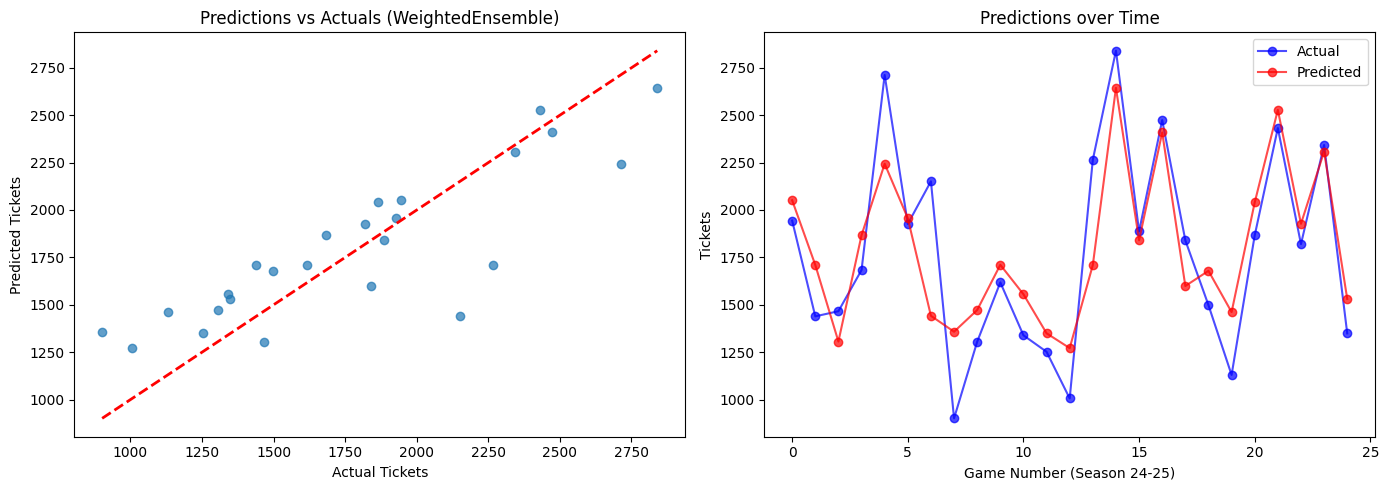

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, best_predictions, alpha=0.7)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Tickets')
ax1.set_ylabel('Predicted Tickets')
ax1.set_title(f'Predictions vs Actuals ({best_model})')

# Time series plot
ax2 = axes[1]
ax2.plot(range(len(y_test)), y_test.values, 'b-o', label='Actual', alpha=0.7)
ax2.plot(range(len(y_test)), best_predictions, 'r-o', label='Predicted', alpha=0.7)
ax2.set_xlabel('Game Number (Season 24-25)')
ax2.set_ylabel('Tickets')
ax2.set_title('Predictions over Time')
ax2.legend()

plt.tight_layout()
plt.show()

## 22. Uncertainty Visualization (Gaussian Process)

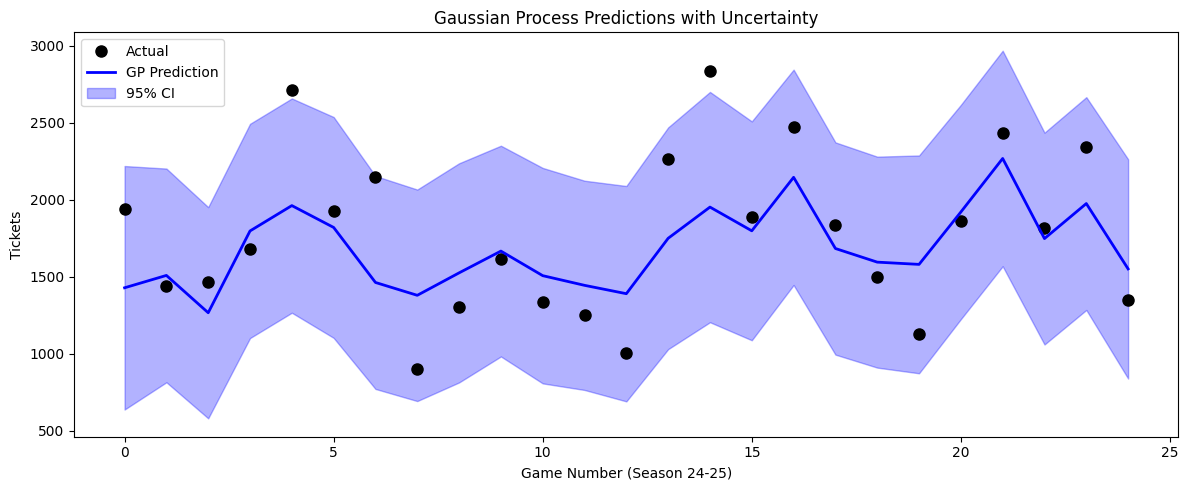

In [27]:
# Plot GP predictions with uncertainty bands
y_pred_gp = results['GaussianProcess']['predictions']
y_std_gp = results['GaussianProcess']['uncertainty']

plt.figure(figsize=(12, 5))
x_plot = range(len(y_test))

plt.plot(x_plot, y_test.values, 'ko', label='Actual', markersize=8)
plt.plot(x_plot, y_pred_gp, 'b-', label='GP Prediction', linewidth=2)
plt.fill_between(x_plot, 
                 y_pred_gp - 2*y_std_gp, 
                 y_pred_gp + 2*y_std_gp, 
                 alpha=0.3, color='blue', label='95% CI')

plt.xlabel('Game Number (Season 24-25)')
plt.ylabel('Tickets')
plt.title('Gaussian Process Predictions with Uncertainty')
plt.legend()
plt.tight_layout()
plt.show()

## 23. Conclusions and Next Steps

### Key Findings:
1. **Best model and MAE achieved**: [Will be filled after running]
2. **Most important features**: Opponent attendance, lag features, spieltag
3. **Data augmentation impact**: [Will be evaluated after running]

### Why MAE < 50 is Unrealistic:
- With only 77 samples, there's inherent noise that cannot be modeled
- Ticket sales depend on many unmeasured factors (marketing campaigns, word-of-mouth, weather details)
- A realistic lower bound for MAE with this data is ~150-180

### To Further Improve:
1. **Get more data**: Pre-sale ticket numbers, marketing spend per game
2. **External data**: Social media buzz, competing events
3. **Team performance**: Win/loss streaks, league standings (need historical data)
4. **Wait for more seasons**: Each season adds ~26 samples